# Assignment 2 Group 15 Data Visualization<br>
## Index
1. Import Requirements
2. 

In [3]:
## Import requirements
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

In [4]:
## Collect data from ElasticSearch
from elasticsearch import helpers

ELASTIC_SEARCH_SERVER= "https://localhost:9200"
es = Elasticsearch(ELASTIC_SEARCH_SERVER, basic_auth=("elastic", "elastic"), verify_certs=False)

# Test the elastic cluster health
try:
    health = es.cluster.health()
    print("Cluster health:", health)
except Exception as e:
    print(f"Error connecting to Elasticsearch: {e}")

# Indexs of data
weather_index = "weather-data"
traffic_index_2023 = "traffic-2023"
income_index = "all_states_income-data"

index_list = [weather_index, traffic_index_2023, income_index] 

# Create empty lists for weather, income, and traffic data
weather_data = []
income_data = []
traffic_2023_data = []

for ind in index_list:
    response = es.search(index=ind, body={
    'size': 10000,
    'query': {
        'match_all': {}
    }})

    hits = response['hits']['hits']
    data = [hit['_source'] for hit in hits]
    
    if ind == weather_index:
        weather_data.extend(data)
    elif ind == income_index:
        income_data.extend(data)
    elif ind == traffic_index_2023:  
        traffic_2023_data.extend(data)

# Convert the lists to dataframes
weather_df = pd.DataFrame(weather_data)
income_df = pd.DataFrame(income_data)
traffic_2023_df = pd.DataFrame(traffic_2023_data)  

print(weather_df)
print(income_df)
print(traffic_2023_df)

    
print(weather_data)

/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Cluster health: {'cluster_name': 'elasticsearch', 'status': 'green', 'timed_out': False, 'number_of_nodes': 2, 'number_of_data_nodes': 2, 'active_primary_shards': 35, 'active_shards': 70, 'relocating_shards': 0, 'initializing_shards': 0, 'unassigned_shards': 0, 'delayed_unassigned_shards': 0, 'number_of_pending_tasks': 0, 'number_of_in_flight_fetch': 0, 'task_max_waiting_in_queue_millis': 0, 'active_shards_percent_as_number': 100.0}
          station_name  latitude  longitude  temperature  \
0             Ballarat     -37.5      143.8         10.9   
1       Yarram Airport     -38.6      146.7         12.1   
2           Point Cook     -37.9      144.8         14.2   
3       Latrobe Valley     -38.2      146.5         12.0   
4             Hamilton     -37.6      142.1         11.6   
...                ...       ...        ...          ...   
1392  Mount Gellibrand     -38.2      143.8          8.4   
1393        Coldstream     -37.7      145.4          9.1   
1394  Mount Gellibrand 

/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
print(weather_df)
print(income_df)
print(traffic_2023_df)

          station_name  latitude  longitude  temperature  \
0             Ballarat     -37.5      143.8         10.9   
1       Yarram Airport     -38.6      146.7         12.1   
2           Point Cook     -37.9      144.8         14.2   
3       Latrobe Valley     -38.2      146.5         12.0   
4             Hamilton     -37.6      142.1         11.6   
...                ...       ...        ...          ...   
1392  Mount Gellibrand     -38.2      143.8          8.4   
1393        Coldstream     -37.7      145.4          9.1   
1394  Mount Gellibrand     -38.2      143.8          7.5   
1395        Coldstream     -37.7      145.4          9.0   
1396        Coldstream     -37.7      145.4          8.8   

      apparent_temperature  humidity  wind_speed_kmh  wind_speed_kt  \
0                      6.8        87              20             11   
1                      6.9        73              24             13   
2                      8.2        69              30             1

In [6]:
for data in weather_data:
    print(data)
# print(weather_data)


{'station_name': 'Ballarat', 'latitude': -37.5, 'longitude': 143.8, 'temperature': 10.9, 'apparent_temperature': 6.8, 'humidity': 87, 'wind_speed_kmh': 20, 'wind_speed_kt': 11, 'gust_speed_kmh': 30, 'gust_speed_kt': 16, 'pressure': 1027.8, 'rainfall': '0.6', 'weather': '-', 'cloud_cover': 'Partly cloudy', 'visibility': '10', 'timestamp': '20240517160000'}
{'station_name': 'Yarram Airport', 'latitude': -38.6, 'longitude': 146.7, 'temperature': 12.1, 'apparent_temperature': 6.9, 'humidity': 73, 'wind_speed_kmh': 24, 'wind_speed_kt': 13, 'gust_speed_kmh': 30, 'gust_speed_kt': 16, 'pressure': 1024.9, 'rainfall': '1.2', 'weather': '-', 'cloud_cover': '-', 'visibility': '-', 'timestamp': '20240517160000'}
{'station_name': 'Point Cook', 'latitude': -37.9, 'longitude': 144.8, 'temperature': 14.2, 'apparent_temperature': 8.2, 'humidity': 69, 'wind_speed_kmh': 30, 'wind_speed_kt': 16, 'gust_speed_kmh': 41, 'gust_speed_kt': 22, 'pressure': 1027.1, 'rainfall': '0.4', 'weather': '-', 'cloud_cover':

In [7]:
weather_df = weather_df.rename(columns={'station_name': 'suburb'})
income_df  = income_df.rename(columns={'lga_name':'suburb'})

# Create a 'State' column based on the 'history_product'
weather_df['State'] = weather_df['history_product'].apply(lambda x: 'NSW' if str(x) == "IDN60801" 
                                                 else ('VIC' if str(x) == "IDV60801" 
                                                 else ('QLD' if str(x) == "IDQ60801"  
                                                 else ('SA' if str(x) == "IDS60801" 
                                                 else ('WA' if str(x) == "IDW60801"  
                                                 else ('TAS' if str(x) == "IDT60801"  
                                                 else ('NT' if str(x) == "IDD60801" 
                                                #  else ('ACT' if str(x).startswith('8') 
                                                 else 'Other')))))))

def extract_month(timestamp):
    # The month is represented by the 5th and 6th characters in the timestamp string
    month = int(timestamp[4:6])
    return month

# Create a 'Month' column based on the 'timestamp'
weather_df['Month'] = weather_df['timestamp'].apply(extract_month)


# Merge weather and income by station
merged_df_station = pd.merge(weather_df, income_df, on='suburb', how='inner')
print(merged_df_station)
unique_values = merged_df_station['suburb'].unique()
print(unique_values)

       suburb  latitude  longitude  temperature  apparent_temperature  \
0    Ballarat     -37.5      143.8         10.9                   6.8   
1    Ballarat     -37.5      143.8         10.6                   6.2   
2    Ballarat     -37.5      143.8         10.5                   6.1   
3    Ballarat     -37.5      143.8         10.1                   5.3   
4    Ballarat     -37.5      143.8         11.0                   6.7   
..        ...       ...        ...          ...                   ...   
181  Ballarat     -37.5      143.8          8.1                   3.2   
182  Ballarat     -37.5      143.8          8.5                   4.1   
183  Ballarat     -37.5      143.8          9.2                   4.7   
184  Ballarat     -37.5      143.8         10.0                   5.6   
185  Ballarat     -37.5      143.8         10.4                   6.2   

     humidity  wind_speed_kmh  wind_speed_kt  gust_speed_kmh  gust_speed_kt  \
0          87              20             11

Mean Rainfall for Ballarat: 0.4698924731182796
Mean Income for Ballarat: 54393.0


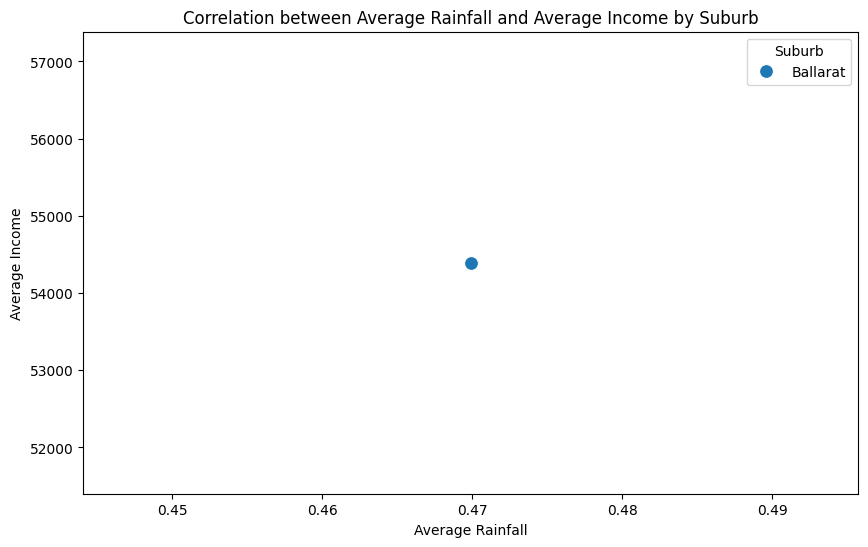

In [17]:
# Find Correlation between the average weather and average income of the suburb.

mean_data_list = []

for suburb in unique_values:
    # Filter rows for the current suburb
    suburb_data = merged_df_station[merged_df_station['suburb'] == suburb]

    suburb_data['rainfall'] = pd.to_numeric(suburb_data['rainfall'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and 'income'
    mean_rainfall = suburb_data['rainfall'].mean()
    mean_income = suburb_data['mean_aud'].mean()
    
    mean_data_list.append({'suburb': suburb, 'mean_rainfall': mean_rainfall, 'mean_income': mean_income})

# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_rainfall', y='mean_income', hue='suburb', data=mean_data_df, s=100)
plt.title('Correlation between Average Rainfall and Average Income by Suburb')
plt.xlabel('Average Rainfall')
plt.ylabel('Average Income')
#plt.legend(title='Suburb')
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_rainfall'].corr(mean_data_df['mean_income'])

print(f"Correlation between Average Rainfall and Average Income: {correlation}")

In [ ]:
# traffic_2023_df

# Merge weather and traffic_2023_df by State
merged_df_state = pd.merge(weather_df, traffic_2023_df, on='State', how='inner')
print(merged_df_state)
unique_values = merged_df_state['State'].unique()
print(unique_values)

In [ ]:
# Find Correlation between the average weather of certain month and amount of traffic accidents of the certain month for one State.

mean_data_list = []

for state in unique_values:
    # Filter rows for the current State
    state_data = merged_df_state[merged_df_state['State'] == state]

    state_data['rainfall'] = pd.to_numeric(state_data['rainfall'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and count of accidents
    mean_rainfall = state_data['rainfall'].mean()
    count_accident = (state_data['State'] == state).sum()
    
    mean_data_list.append({'State': state, 'mean_rainfall': mean_rainfall, 'count_accident': count_accident})

# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_rainfall', y='count_accident', hue='State', data=mean_data_df, s=100)
plt.title('Correlation between Average Rainfall and Accident Count by State')
plt.xlabel('Average Rainfall')
plt.ylabel('Accident Count')
plt.legend(title='State')
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_rainfall'].corr(mean_data_df['count_accident'])

print(f"Correlation between Average Rainfall and Accident Count: {correlation}")


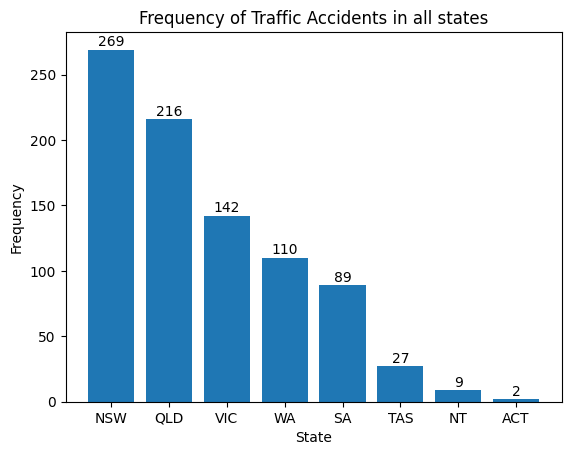

In [9]:
# Capitalised the State
traffic_2023_df['State'] = traffic_2023_df['State'].str.upper()

# Get the frequency count of each state
state_counts = traffic_2023_df['State'].value_counts()

# Create a bar plot of the state counts
bars = plt.bar(state_counts.index, state_counts.values)

# Add the frequency count on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Frequency of Traffic Accidents in all states')
plt.xlabel('State')
plt.ylabel('Frequency')

# Show the plot
plt.show()

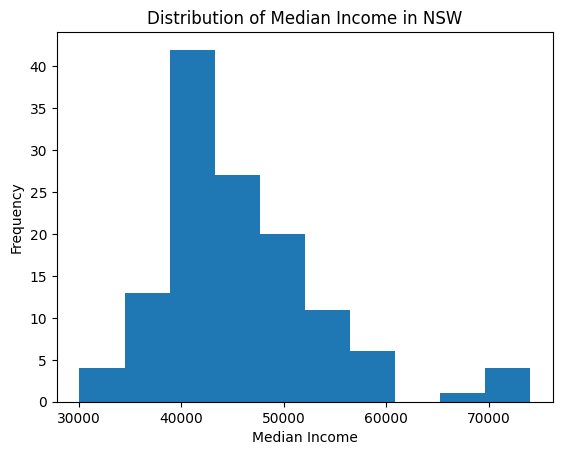

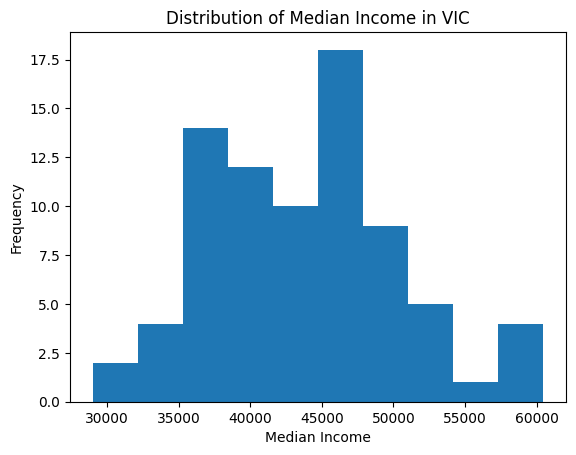

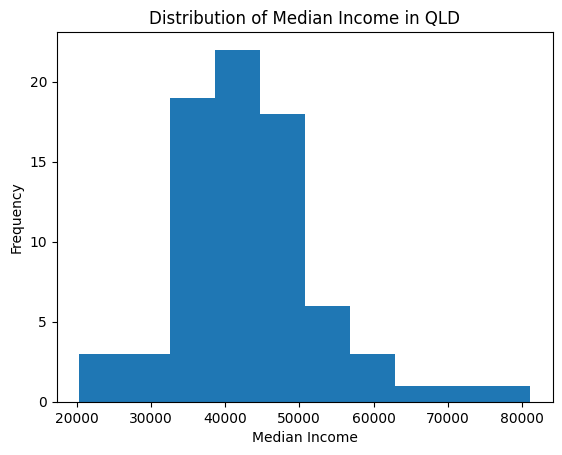

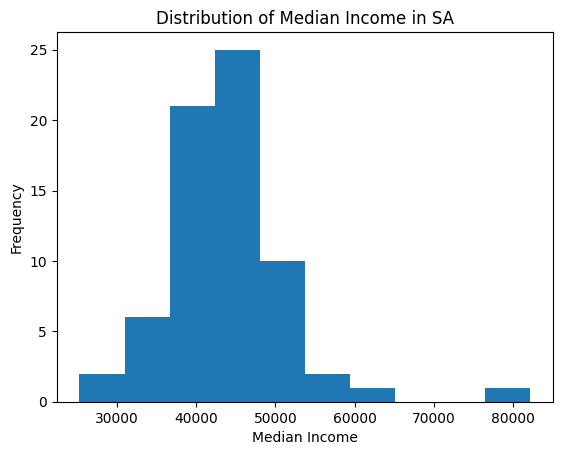

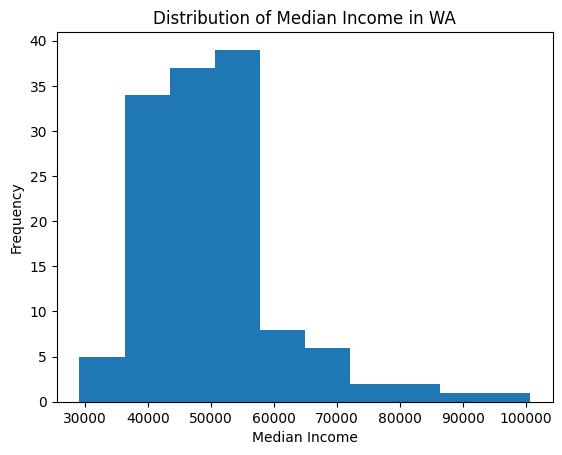

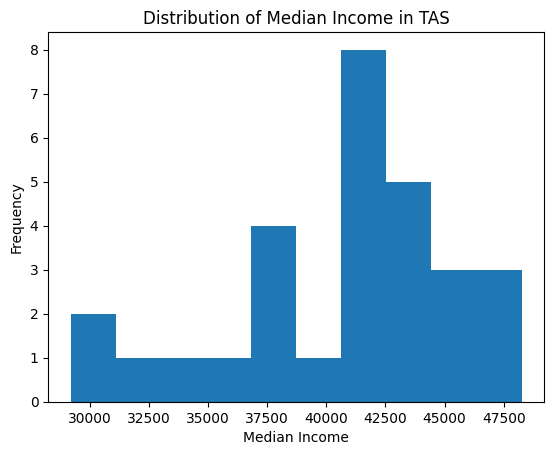

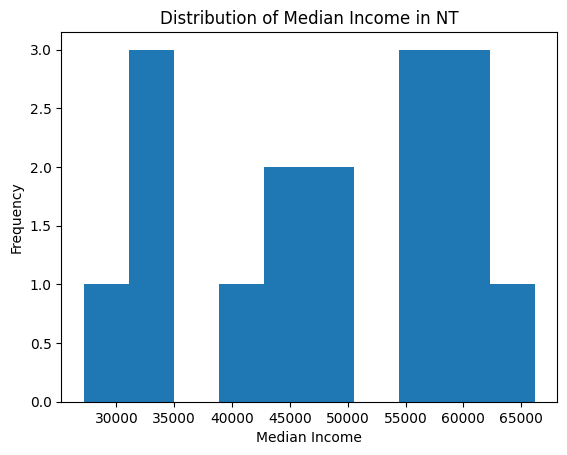

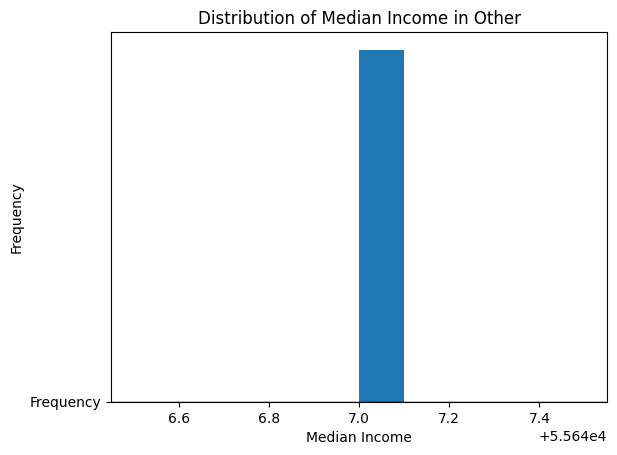

Median income for VIC: 43223.0
Median income for NSW: 44529.0
Median income for QLD: 42101.0
Median income for SA: 44027.0
Median income for WA: 48650.0
Median income for TAS: 42073.0
Median income for NT: 48834.5


In [11]:
# Create a 'State' column based on the 'lga_code'
income_df['State'] = income_df['lga_code'].apply(lambda x: 'NSW' if str(x).startswith('1') 
                                                 else ('VIC' if str(x).startswith('2') 
                                                 else ('QLD' if str(x).startswith('3') 
                                                 else ('SA' if str(x).startswith('4') 
                                                 else ('WA' if str(x).startswith('5') 
                                                 else ('TAS' if str(x).startswith('6') 
                                                 else ('NT' if str(x).startswith('7') 
                                                #  else ('ACT' if str(x).startswith('8') 
                                                 else 'Other')))))))

# for state in ['VIC', 'NSW']:
#     plt.figure()  # Create a new figure
#     state_df = income_df[income_df['State'] == state]
#     state_df['median_aud'].hist(grid=False)
#     plt.title(f'Distribution of Median Income in {state}')
#     plt.xlabel('Median Income')
#     plt.ylabel('Frequency')
# plt.show()

# Loop through each unique state
for state in income_df['State'].unique():
    plt.figure()  # Create a new figure
    state_df = income_df[income_df['State'] == state]
    state_df['median_aud'].hist(grid=False)
    plt.title(f'Distribution of Median Income in {state}')
    plt.xlabel('Median Income')
    plt.ylabel('Frequency')

plt.show()


vic_median = income_df[income_df['State'] == 'VIC']['median_aud'].median()
nsw_median = income_df[income_df['State'] == 'NSW']['median_aud'].median()
qld_median = income_df[income_df['State'] == 'QLD']['median_aud'].median()
sa_median = income_df[income_df['State'] == 'SA']['median_aud'].median()
wa_median = income_df[income_df['State'] == 'WA']['median_aud'].median()
tas_median = income_df[income_df['State'] == 'TAS']['median_aud'].median()
nt_median = income_df[income_df['State'] == 'NT']['median_aud'].median()
# act_median = income_df[income_df['State'] == 'ACT']['median_aud']

# print(income_df[income_df['State'] == 'ACT']['median_aud'])


# Print the medians
print(f"Median income for VIC: {vic_median}")
print(f"Median income for NSW: {nsw_median}")
print(f"Median income for QLD: {qld_median}")
print(f"Median income for SA: {sa_median}")
print(f"Median income for WA: {wa_median}")
print(f"Median income for TAS: {tas_median}")
print(f"Median income for NT: {nt_median}")
# print(f"Median income for ACT: {act_median}")

# Check the data for ACT
# act_data = income_df[income_df['State'] == 'ACT']
# print(act_data['median_aud'].describe())



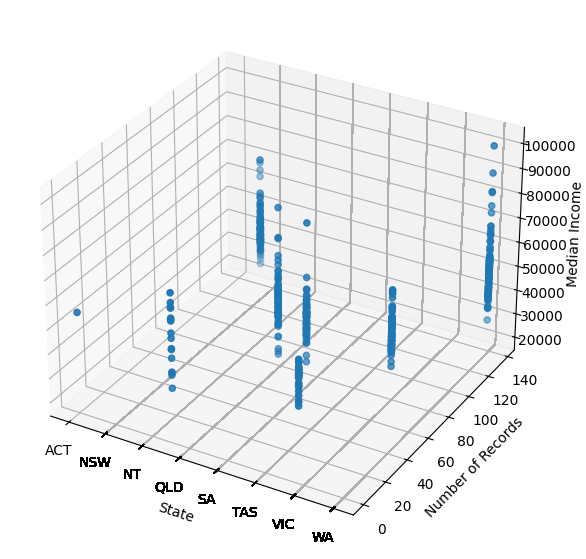

In [252]:
# Calculate the frequency for each state
state_counts = income_df['State'].value_counts()

# Add a column for state counts to the income_df
income_df['Frequency'] = income_df['State'].apply(lambda x: state_counts[x])

# Convert 'State' to categorical codes
income_df['State_Code'] = income_df['State'].astype('category').cat.codes

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
scatter = ax.scatter(income_df['State Code'], income_df['Frequency'], income_df['median_aud'])

ax.set_xlabel('State')
ax.set_ylabel('Number of Records')
ax.set_zlabel('Median Income')

# Set the x-tick labels to the 'State' strings
ax.set_xticks(income_df['State_Code'])
ax.set_xticklabels(income_df['State'])
plt.show()

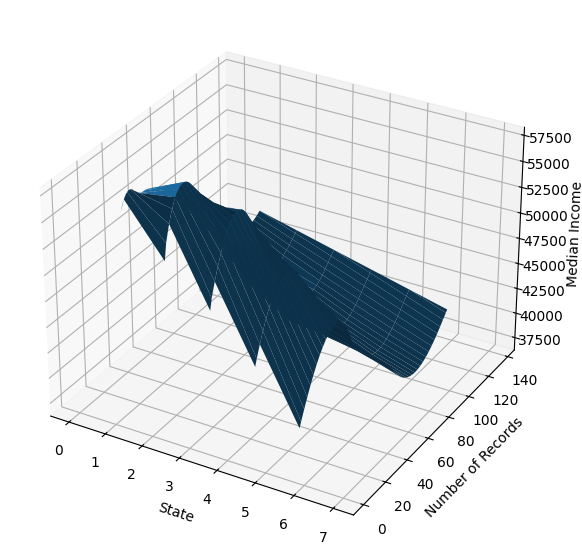

In [266]:
# Create a grid of x and y values
x = np.linspace(income_df['State_Code'].min(), income_df['State_Code'].max(), len(income_df['State'].unique()))
y = np.linspace(income_df['Frequency'].min(), income_df['Frequency'].max(), 100)
x_grid, y_grid = np.meshgrid(x, y)

z_grid = griddata((income_df['State_Code'], income_df['Frequency']), income_df['median_aud'], (x_grid, y_grid), method='cubic')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_grid, y_grid, z_grid)

ax.set_xlabel('State')
ax.set_ylabel('Number of Records')
ax.set_zlabel('Median Income')

# Show the plot
plt.show()

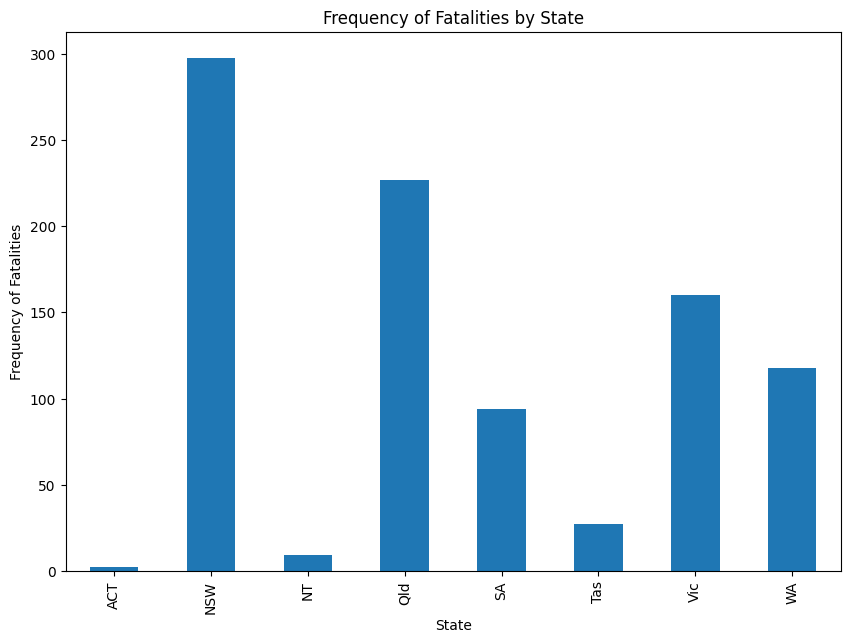

In [268]:
state_fatalities = traffic_2023_df.groupby('State')['Number Fatalities'].sum()

# Create a bar plot
state_fatalities.plot(kind='bar', figsize=(10, 7))

# Set the title and labels
plt.title('Frequency of Fatalities by State')
plt.xlabel('State')
plt.ylabel('Frequency of Fatalities')

# Show the plot
plt.show()

-0.003405404842709764


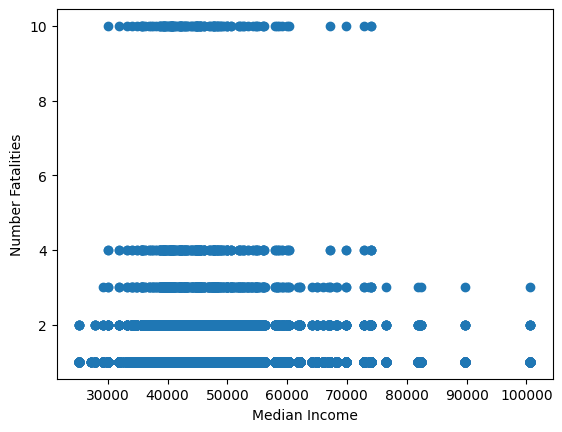

In [272]:
# Convert the 'Number Fatalities' column to numeric
traffic_2023_df['Number Fatalities'] = pd.to_numeric(traffic_2023_df['Number Fatalities'], errors='coerce')
traffic_grouped = traffic_2023_df.groupby('State')['Number Fatalities'].sum()

traffic_state_counts = traffic_2023_df['State'].value_counts()

# Calculate the median of 'median_aud' for each state
income_grouped = income_df.groupby('State')['median_aud'].median()
merged_df = pd.merge(traffic_2023_df, income_df, on='State')

# Calculate the correlation between 'Number Fatalities' and 'median_income'
correlation = merged_df['Number Fatalities'].corr(merged_df['median_aud'])


print(correlation)

plt.scatter(merged_df['median_aud'], merged_df['Number Fatalities'])

plt.axvline(x = 2.5, ymin = 0, ymax = 10, color ='red')
# Set the labels
plt.xlabel('Median Income')
plt.ylabel('Number Fatalities')

# Show the plot
plt.show()



In [13]:
print(income_df.groupby('State')['median_aud'])